In [1]:
# Ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Import library
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import parallel_backend

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import time
from tqdm import tqdm_notebook as tqdm



# Set the seed for randomization
seed = 0


## Helper Functions

In [2]:
def taxi_data_preprocess(taxi_data, taxi_type):
    
    # Convert data type for categorical attribute
    taxi_data.VendorID = taxi_data.VendorID.astype(object)
    taxi_data.RatecodeID = taxi_data.RatecodeID.astype(object)
    taxi_data.PULocationID = taxi_data.PULocationID.astype(object)
    taxi_data.DOLocationID = taxi_data.DOLocationID.astype(object)
    taxi_data.payment_type = taxi_data.payment_type.astype(object)
    
    if taxi_type == 'yellow':
        # Convert data type for date attribute
        taxi_data.tpep_pickup_datetime = pd.to_datetime(taxi_data.tpep_pickup_datetime)
        taxi_data.tpep_dropoff_datetime = pd.to_datetime(taxi_data.tpep_dropoff_datetime)
    elif taxi_type == 'green':
        # Convert data type for date attribute
        taxi_data.lpep_pickup_datetime = pd.to_datetime(taxi_data.lpep_pickup_datetime)
        taxi_data.lpep_dropoff_datetime = pd.to_datetime(taxi_data.lpep_dropoff_datetime)
    else:
        print('Please provide valid taxi type. yellow/green')
        return
    
    # Compute the duration of each trip and store in a new column, 'duration'
    print('Compute the duration of each taxi trip...')
    if taxi_type == 'yellow':
        taxi_data['duration'] = taxi_data.tpep_dropoff_datetime - taxi_data.tpep_pickup_datetime
    elif taxi_type == 'green':
        taxi_data['duration'] = taxi_data.lpep_dropoff_datetime - taxi_data.lpep_pickup_datetime
    else:
        print('Please provide valid taxi type. yellow/green')
        return
    
    # Create 5 different time period
    print('Create 5 different time period: morning, noon, afternoon, night, latenight...')
    taxi_data['time'] = None
    
    if taxi_type == 'yellow':
        morning = [6 <= time.hour < 11 for time in taxi_data.tpep_pickup_datetime]
        print('Morning is done!')
        noon = [11 <= time.hour < 14 for time in taxi_data.tpep_pickup_datetime]
        print('Noon is done!')
        afternoon = [14 <= time.hour < 18 for time in taxi_data.tpep_pickup_datetime]
        print('Afternoon is done!')
        night = [18 <= time.hour <= 23 for time in taxi_data.tpep_pickup_datetime]
        print('Night is done!')
        latenight = [0 <= time.hour < 6 for time in taxi_data.tpep_pickup_datetime]
        print('Latenight is done!')
    elif taxi_type == 'green':
        morning = [6 <= time.hour < 11 for time in taxi_data.lpep_pickup_datetime]
        print('Morning is done!')
        noon = [11 <= time.hour < 14 for time in taxi_data.lpep_pickup_datetime]
        print('Noon is done!')
        afternoon = [14 <= time.hour < 18 for time in taxi_data.lpep_pickup_datetime]
        print('Afternoon is done!')
        night = [18 <= time.hour <= 23 for time in taxi_data.lpep_pickup_datetime]
        print('Night is done!')
        latenight = [0 <= time.hour < 6 for time in taxi_data.lpep_pickup_datetime]
        print('Latenight is done!')
    else:
        print('Please provide valid taxi type. yellow/green')
        return
    
    taxi_data.loc[morning,'time'] = 'Morning'
    taxi_data.loc[noon,'time'] = 'Noon'
    taxi_data.loc[afternoon,'time'] = 'Afternoon'
    taxi_data.loc[night,'time'] = 'Night'
    taxi_data.loc[latenight,'time'] = 'Latenight'
    
    # Remove unreasonable records
    print('Remove unreasonable records...')
    # 1. Taxi trips that have negative or zero duration
    print('Remove trip records whose dropoff time is earlier than pickup time...')
    if taxi_type == 'yellow':
        taxi_data = taxi_data.loc[taxi_data.tpep_dropoff_datetime > taxi_data.tpep_pickup_datetime,]
    elif taxi_type == 'green':
        taxi_data = taxi_data.loc[taxi_data.lpep_dropoff_datetime > taxi_data.lpep_pickup_datetime,]
    # 2. Taxi trips that last longer than 24 hours
    print('Remove trip records that last longer than 24 hours or have negative duration time...')
    taxi_data = taxi_data.loc[[duration.days == 0 for duration in taxi_data.duration],]
    # 3. Taxi trips that travel more than 30 miles
    print('Remove trip records that travel more than 30 miles...')
    taxi_data = taxi_data.loc[taxi_data.trip_distance <= 30,]
    # 4. Taxi trips with non-positive total amount 
    print('Remove trip records that have negative or zero total amount...')
    taxi_data = taxi_data.loc[taxi_data.total_amount > 0,]
    
    # Compute the income/second
    print('Compute the income per second for each trip in dollar amount...')
    taxi_data['income_per_second'] = [income/time.total_seconds() for income,time in zip(taxi_data.total_amount,taxi_data.duration)]
    
    # R
    print('Remove data points with extreme values in the following attributes: income_per_second, tip_amount, total_amount...')
    taxi_data = taxi_data.loc[taxi_data.income_per_second <= 0.06,]
    taxi_data = taxi_data.loc[taxi_data.tip_amount <= 16,]
    taxi_data = taxi_data.loc[taxi_data.total_amount <= 77,]
    
    # Reset row index
    print('Reset row index...')
    taxi_data.reset_index(inplace = True, drop = True)
    
    print('Taxi data preprocess completed!')
    
    return taxi_data

In [3]:
def add_March_weather(taxi_data, taxi_type):
    print('Add weather warnings for March data...')
    # Create weather column in taxi data
    taxi_data['weather'] = 'None'
    # List of dates that have winter storm warning
    winter_storm_date = [6,7,8,20,22]
    # True/False vector to indicate whether trip was impacted by the weather or not
    if taxi_type == 'yellow':
        impact = [time.day in winter_storm_date for time in taxi_data.tpep_pickup_datetime]
    elif taxi_type == 'green':
        impact = [time.day in winter_storm_date for time in taxi_data.lpep_pickup_datetime]
    else:
        print('Please provide valid taxi type. yellow/green')
        return
    # Label impacted trips
    taxi_data.loc[impact,'weather'] = 'Winter Storm'
    print('Weather warnings have been added!')
    
    return taxi_data

In [4]:
def add_August_weather(taxi_data, taxi_type):
    print('Add weather warnings for August data...')
    # Create weather column in taxi data
    taxi_data['weather'] = 'None'
    # List of dates that have winter storm warning
    thunderstorm_date = [7,11]
    # True/False vector to indicate whether trip was impacted by the weather or not
    if taxi_type == 'yellow':
        impact = [time.day in thunderstorm_date for time in taxi_data.tpep_pickup_datetime]
    elif taxi_type == 'green':
        impact = [time.day in thunderstorm_date for time in taxi_data.lpep_pickup_datetime]
    else:
        print('Please provide valid taxi type. yellow/green')
        return
    # Label impacted trips
    taxi_data.loc[impact,'weather'] = 'Thunderstorm'
    print('Weather warnings have been added!')
    
    return taxi_data

In [5]:
def compare_time_density(taxi_data, feature, fig_width, fig_height, xlab, title, xlim = None):
    # Plot income_per_second for different time in a day
    fig, ax = plt.subplots(figsize = (fig_width, fig_height))

    sns.distplot(taxi_data.loc[taxi_data.time == 'Latenight', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.time == 'Night', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.time == 'Afternoon', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.time == 'Morning', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.time == 'Noon', feature], ax = ax)

    ax.legend(['Latenight','Night','Afternoon','Morning','Noon']); ax.set_ylabel('Density');
    ax.set_title(title); ax.set_xlabel(xlab);
    
    if xlim:
        ax.set_xlim(0,xlim);
    
    return ax

In [6]:
def compare_WS_density(taxi_data, feature, fig_width, fig_height, xlab, title, xlim = None):
    # Plot income_per_second for different time in a day
    fig, ax = plt.subplots(figsize = (fig_width, fig_height))

    sns.distplot(taxi_data.loc[taxi_data.weather == 'Winter Storm', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.weather == 'None', feature], ax = ax)
    
    ax.legend(['Winter Storm','None']); ax.set_ylabel('Density');
    ax.set_title(title); ax.set_xlabel(xlab);
    
    if xlim:
        ax.set_xlim(0,xlim);
    
    return ax

In [7]:
def compare_SV_density(taxi_data, feature, fig_width, fig_height, xlab, title, xlim = None):
    # Plot income_per_second for different time in a day
    fig, ax = plt.subplots(figsize = (fig_width, fig_height))

    sns.distplot(taxi_data.loc[taxi_data.weather == 'Thunderstorm', feature], ax = ax)
    sns.distplot(taxi_data.loc[taxi_data.weather == 'None', feature], ax = ax)
    
    ax.legend(['Thunderstorm','None']); ax.set_ylabel('Density');
    ax.set_title(title); ax.set_xlabel(xlab);
    
    if xlim:
        ax.set_xlim(0,xlim);
    
    return ax

In [8]:
def compare_group_boxplot(taxi_data, group, feature, ylab, title, ax = None, fig_width = None, fig_height = None):
    
    if ax:
        sns.boxplot(x = group, y = feature, data = taxi_data, ax = ax)
    else:
        fig, ax = plt.subplots(figsize = (fig_width, fig_height))
        sns.boxplot(x = group, y = feature, data = taxi_data, ax = ax)
    
    ax.set_title(title); ax.set_ylabel(ylab);

In [9]:
# One-hot encoding
def one_hot(data):
    '''
    11/17/2018, Kefu Zhu

    Input: data, Pandas.DataFrame object
    Output: one hot encoded data
    '''

    # Required library
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    # Extract categorical data
    categorical_data = data.select_dtypes(include = ['object'])
    # Extract numerical data
    numerical_data = data.select_dtypes(exclude = ['object'])
    # One hot encoding for categorical data
    encoded_x = None
    for i in range(0, categorical_data.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(categorical_data.iloc[:,i])
        feature = feature.reshape(categorical_data.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False)
        feature = onehot_encoder.fit_transform(feature)
        if encoded_x is None:
            encoded_x = feature
        else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
    # Reset the cateogircal_data with one-hot encoded values
    categorical_data = pd.DataFrame(encoded_x, index = categorical_data.index)
    # Combine numerical and categorical data
    one_hot_data = pd.concat([numerical_data, categorical_data], axis = 1)

    return one_hot_data

In [29]:
def DBSCAN_taxi_data(taxi_data, min_sample_num, numeric_feature = None, categorical_feature = None):

    if numeric_feature:
        print('Normalize numeric attributes...')
        numeric_X = taxi_data.loc[:,numeric_feature]
        numeric_X_norm = StandardScaler().fit_transform(numeric_X)
        print('Start the computation of DBSCAN...')
        start = time.time()
        db = DBSCAN(metric = 'euclidean', min_samples = min_sample_num, n_jobs = -1).fit(numeric_X_norm)
        end = time.time()
        print('DBSCAN on {:,} data points took {:.2f} minutes'.format(len(numeric_X_norm), (end-start)/60))
    elif categorical_feature:
        print('One-Hot encoding categorical attributes...')
        categorical_X = taxi_data.loc[:,categorical_attribute]
        categorical_X_oneHot = one_hot(data = categorical_X)
        categorical_X_oneHot.columns = ['RatecodeID_1','RatecodeID_not_1',
                                        'payment_type_1','payment_type_2','payment_type_3','payment_type_4',
                                        'Afternoon','Latenight','Morning','Night','Noon']
        print('Start the computation of DBSCAN...')
        start = time.time()
        db = DBSCAN(metric = 'hamming', min_samples = min_sample_num, n_jobs = -1).fit(categorical_X_oneHot)
        end = time.time()
        print('DBSCAN on {:,} data points took {:.2f} minutes'.format(categorical_X_oneHot.shape[0], (end-start)/60))
        
    else:
        print('Please provide features for the clustering')
        return
    
    return db

In [11]:
def Visualize_DBSCAN(taxi_data_cluster, label, fig_width, fig_height):
    
    # Don't visualize the noise data points
    taxi_data_cluster = taxi_data_cluster.loc[taxi_data_cluster.loc[:,label] != -1,]
    # Plot
    if label == 'DBSCAN_numeric_label':
        # Create four subplots (3x2)
        fig, ax = plt.subplots(3,2,figsize=(fig_width,fig_height));
        
        sns.boxplot(x=label,y='passenger_count',data=taxi_data_cluster, ax = ax[0][0]);
        sns.boxplot(x=label,y='trip_distance',data=taxi_data_cluster, ax = ax[0][1]);
        sns.boxplot(x=label,y='total_amount',data=taxi_data_cluster, ax = ax[1][0]);
        sns.boxplot(x=label,y='tip_amount',data=taxi_data_cluster, ax = ax[1][1]);
        sns.boxplot(x=label,y='duration_seconds',data=taxi_data_cluster, ax = ax[2][0]);
    elif label == 'DBSCAN_categorical_label':
        # Create four subplots (2x2)
        fig, ax = plt.subplots(2,2,figsize=(fig_width,fig_height));
        
        sns.catplot(y='RatecodeID',hue=label, kind='count',data=taxi_data_cluster, ax = ax[0][0]);
        sns.catplot(y='payment_type',hue=label, kind='count',data=taxi_data_cluster, ax = ax[0][1]);
        sns.catplot(y='time',hue=label, kind='count',data=taxi_data_cluster, ax = ax[1][0]);
        plt.close(2);plt.close(3);plt.close(4);
    else:
        pass
    
    return ax

In [22]:
weather_data = pd.read_csv('../data/NYC_2018_weather.csv')
weather_data.drop_duplicates()

,PHENOM,start,end
0,WS,201801032020,201801050600
5,WS,201802170832,201802181200
7,WS,201803060849,201803080900
12,WS,201803070911,201803080900
13,WS,201803200744,201803221200
18,SV,201805152051,201805152145
23,SV,201805152128,201805152215
26,SV,201807272045,201807272130
28,SV,201807272114,201807272200
31,TO,201808030218,201808030245


# Yellow Taxi

In [12]:
start = time.time()
# Load the csv file into pandas dataframe
yellow_taxi_March = pd.read_csv('../data/yellow_tripdata_2018-03.csv')
# Preprocess the taxi data
yellow_taxi_March = taxi_data_preprocess(yellow_taxi_March, taxi_type = 'yellow')
# Add weather info
yellow_taxi_March = add_March_weather(taxi_data = yellow_taxi_March, taxi_type = 'yellow')
end = time.time()
print('Entire process took {:.2f} minutes'.format((end-start)/60))

Compute the duration of each taxi trip...
Create 5 different time period: morning, noon, afternoon, night, latenight...
Morning is done!
Noon is done!
Afternoon is done!
Night is done!
Latenight is done!
Remove unreasonable records...
Remove trip records whose dropoff time is earlier than pickup time...
Remove trip records that last longer than 24 hours or have negative duration time...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Compute the income per second for each trip in dollar amount...
Remove data points with extreme values in the following attributes: income_per_second, tip_amount, total_amount...
Reset row index...
Taxi data preprocess completed!
Add weather warnings for March data...
Weather warnings have been added!
Entire process took 6.31 minutes


In [13]:
start = time.time()
# Load the csv file into pandas dataframe
yellow_taxi_August = pd.read_csv('../data/yellow_tripdata_2018-08.csv')
# Preprocess the taxi data
yellow_taxi_August = taxi_data_preprocess(yellow_taxi_August, taxi_type = 'yellow')
# Add weather info
yellow_taxi_August = add_August_weather(taxi_data = yellow_taxi_August, taxi_type = 'yellow')
end = time.time()
print('Entire process took {:.2f} minutes'.format((end-start)/60))

Compute the duration of each taxi trip...
Create 5 different time period: morning, noon, afternoon, night, latenight...
Morning is done!
Noon is done!
Afternoon is done!
Night is done!
Latenight is done!
Remove unreasonable records...
Remove trip records whose dropoff time is earlier than pickup time...
Remove trip records that last longer than 24 hours or have negative duration time...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Compute the income per second for each trip in dollar amount...
Remove data points with extreme values in the following attributes: income_per_second, tip_amount, total_amount...
Reset row index...
Taxi data preprocess completed!
Add weather warnings for August data...
Weather warnings have been added!
Entire process took 5.04 minutes


## 1. Compare Driver Income by Different Time of a Day

### 1.1 Income per Second

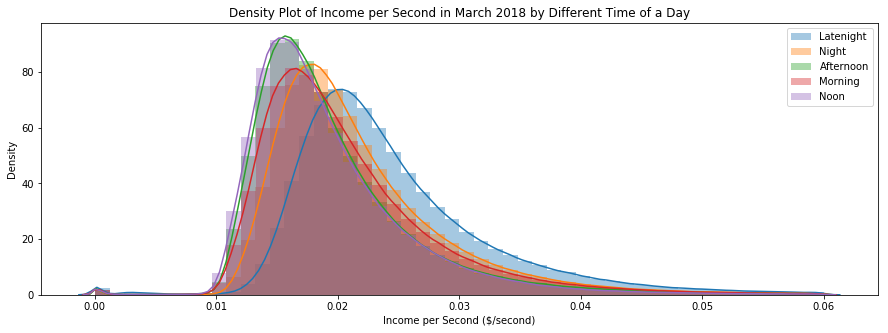

In [38]:
compare_time_density(taxi_data = yellow_taxi_March, feature = 'income_per_second', 
                     title = 'Density Plot of Income per Second in March 2018 by Different Time of a Day', 
                     xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

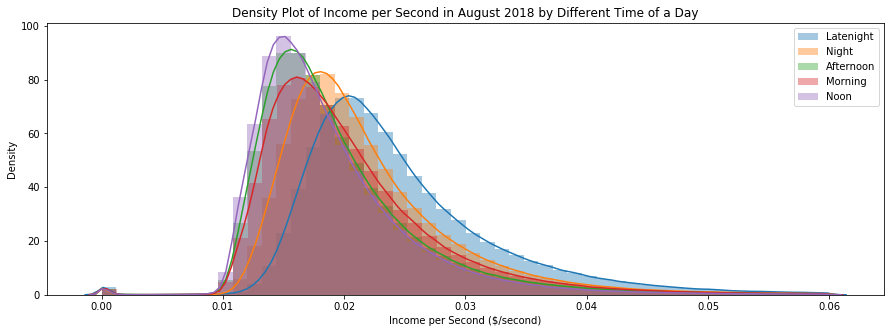

In [39]:
compare_time_density(taxi_data = yellow_taxi_August, feature = 'income_per_second', 
                     title = 'Density Plot of Income per Second in August 2018 by Different Time of a Day', 
                     xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

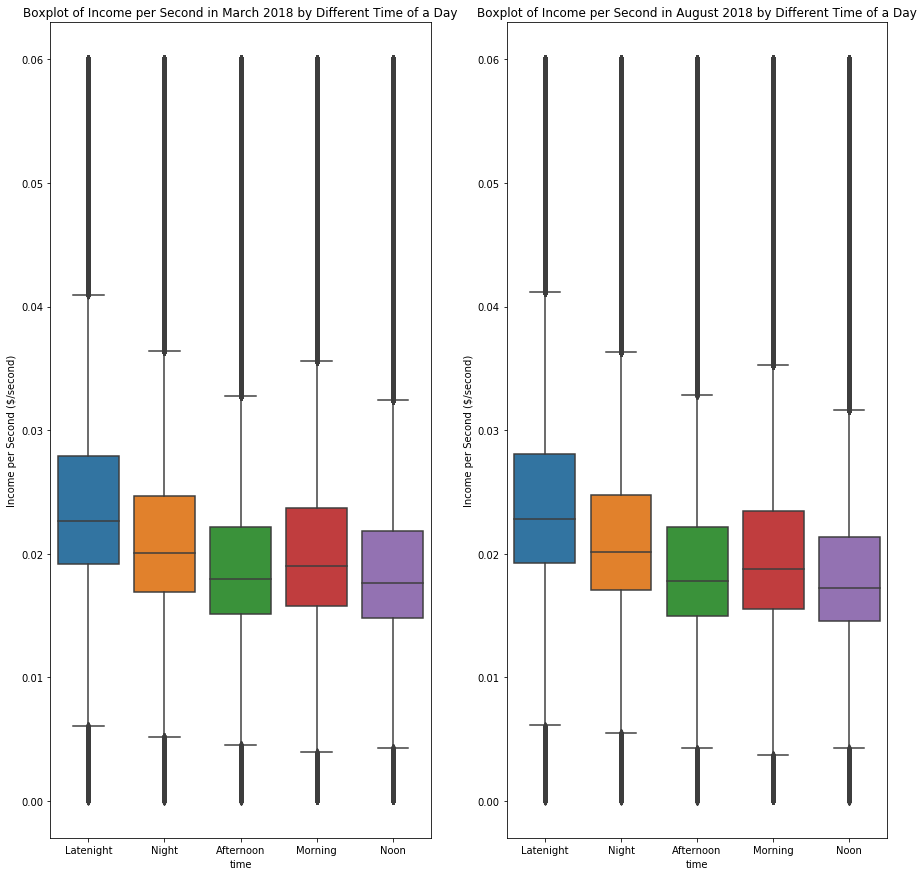

In [63]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,15))

compare_group_boxplot(taxi_data = yellow_taxi_March, group = 'time', feature = 'income_per_second', 
                      title = 'Boxplot of Income per Second in March 2018 by Different Time of a Day',
                      ylab = 'Income per Second ($/second)', ax = ax[0])
compare_group_boxplot(taxi_data = yellow_taxi_August, group = 'time', feature = 'income_per_second', 
                      title = 'Boxplot of Income per Second in August 2018 by Different Time of a Day',
                      ylab = 'Income per Second ($/second)', ax = ax[1])

### 1.2 Total Fare

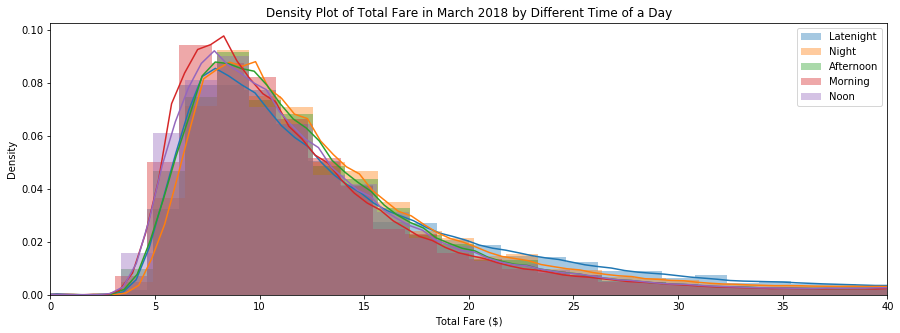

In [59]:
compare_time_density(taxi_data = yellow_taxi_March, feature = 'total_amount', xlim = 40,
                     title = 'Density Plot of Total Fare in March 2018 by Different Time of a Day', 
                     xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

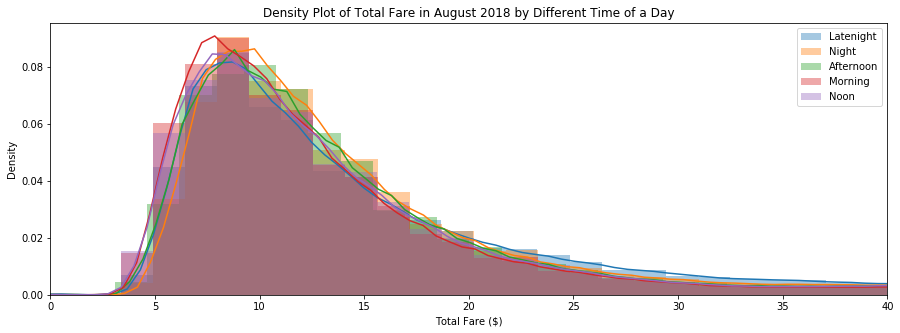

In [60]:
compare_time_density(taxi_data = yellow_taxi_August, feature = 'total_amount', xlim = 40,
                     title = 'Density Plot of Total Fare in August 2018 by Different Time of a Day', 
                     xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

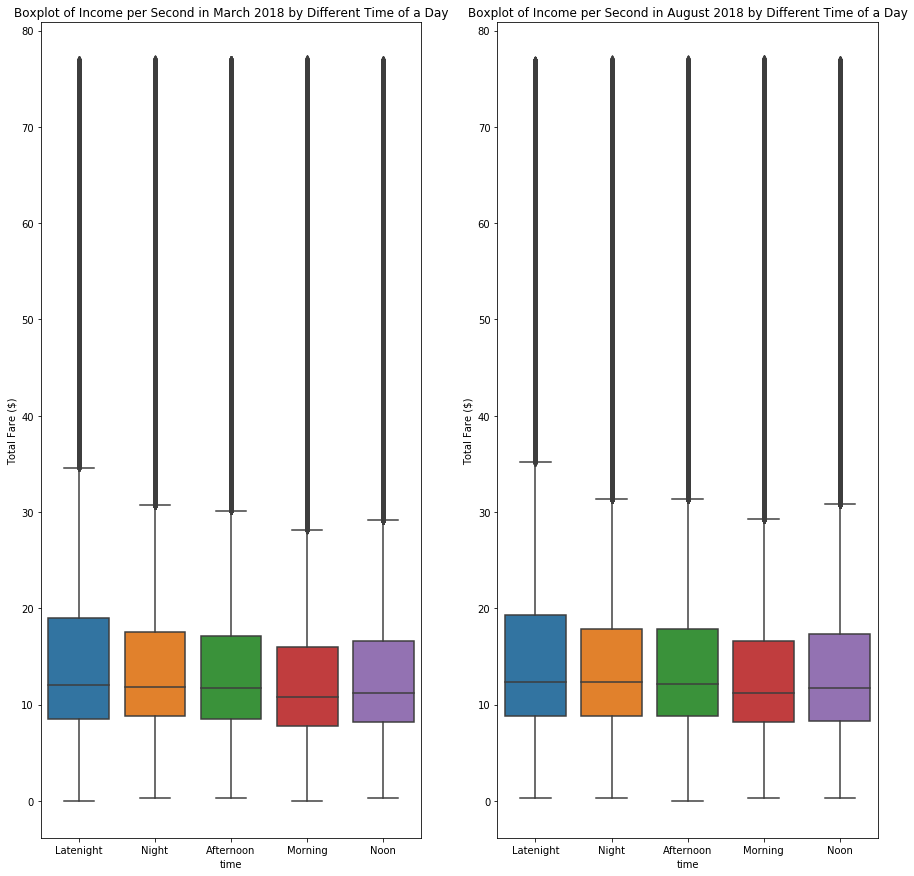

In [64]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,15))

compare_group_boxplot(taxi_data = yellow_taxi_March, group = 'time', feature = 'total_amount', 
                      title = 'Boxplot of Income per Second in March 2018 by Different Time of a Day',
                      ylab = 'Total Fare ($)', ax = ax[0])
compare_group_boxplot(taxi_data = yellow_taxi_August, group = 'time', feature = 'total_amount', 
                      title = 'Boxplot of Income per Second in August 2018 by Different Time of a Day',
                      ylab = 'Total Fare ($)', ax = ax[1])

## 2. Compare Driver Income by Weather

### 2.1 Income per Second

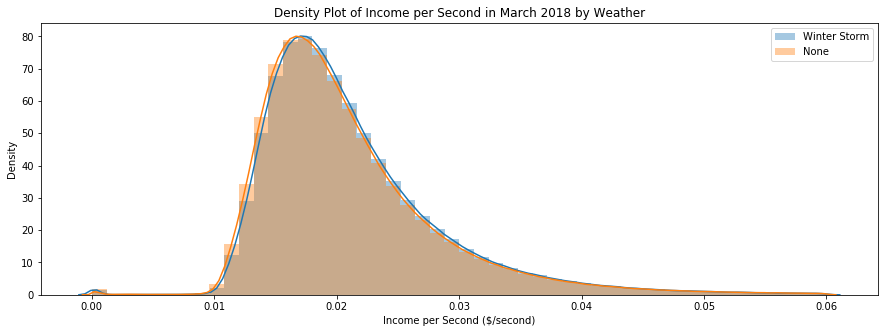

In [73]:
compare_WS_density(taxi_data = yellow_taxi_March, feature = 'income_per_second',
                   title = 'Density Plot of Income per Second in March 2018 by Weather',
                   xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

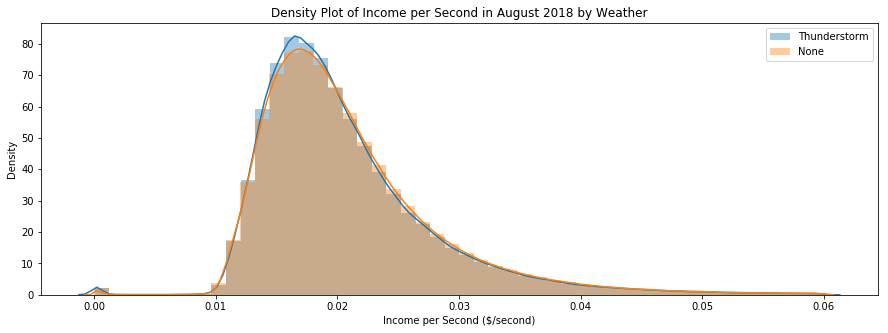

In [74]:
compare_SV_density(taxi_data = yellow_taxi_August, feature = 'income_per_second', 
                   title = 'Density Plot of Income per Second in August 2018 by Weather',
                   xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

### 2.2 Total Fare

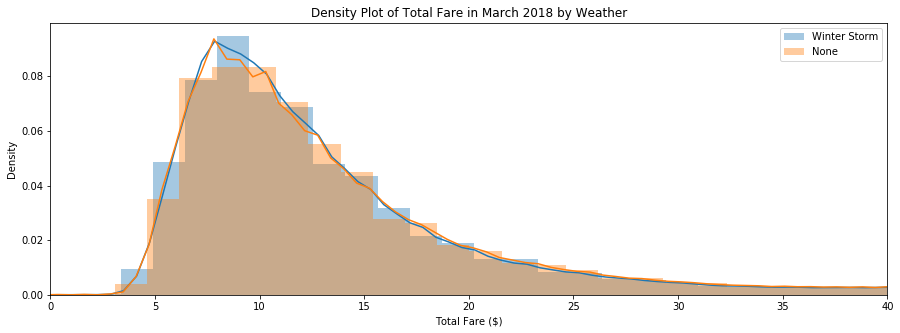

In [77]:
compare_WS_density(taxi_data = yellow_taxi_March, feature = 'total_amount', xlim = 40,
                   title = 'Density Plot of Total Fare in March 2018 by Weather',
                   xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

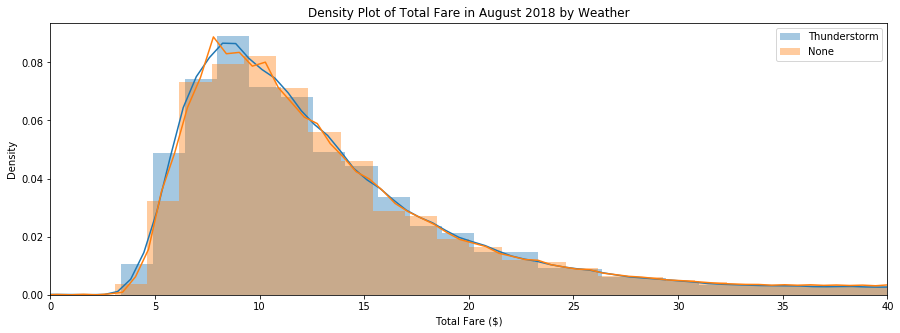

In [78]:
compare_SV_density(taxi_data = yellow_taxi_August, feature = 'total_amount', xlim = 40,
                   title = 'Density Plot of Total Fare in August 2018 by Weather',
                   xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

## 3. Customer Profile - DBSCAN

In [21]:
numeric_attribute = ['passenger_count','trip_distance','total_amount','tip_amount','duration_seconds']
categorical_attribute = ['RatecodeID','payment_type','time']

### 3.1 Numeric Attributes

In [22]:
sample_ratio = 0.02
yellow_taxi_March_sample = yellow_taxi_March.groupby(['time']).apply(lambda x: x.sample(n = round(len(x)*sample_ratio), random_state = seed))
yellow_taxi_March_sample.reset_index(level=0,drop=True,inplace=True) # Drop multilevel index
yellow_taxi_March_sample['duration_seconds'] = [time.seconds for time in yellow_taxi_March_sample.duration]
yellow_taxi_March_sample.RatecodeID = ['1' if ID == 1 else '0' for ID in yellow_taxi_March_sample.RatecodeID]

In [23]:
yellow_taxi_March_sample.shape

(185125, 22)

In [96]:
yellow_DBSCAN_numeric = DBSCAN_taxi_data(taxi_data = yellow_taxi_March_sample, 
                                         min_sample_num = 100, numeric_feature = numeric_attribute)

Prepare the data for DBSCAN clustering...
Start the computation of DBSCAN...
DBSCAN on 185,125 data points took 15.28 minutes


In [162]:
yellow_taxi_March_cluster = yellow_taxi_March_sample
yellow_taxi_March_cluster['DBSCAN_numeric_label'] = yellow_DBSCAN_numeric.labels_

In [23]:
Visualize_DBSCAN(taxi_data_cluster = yellow_taxi_March_cluster, label = 'DBSCAN_numeric_label', 
                 fig_width = 15, fig_height = 15)

NameError: name 'yellow_taxi_March_cluster' is not defined

### 3.2 Categorical Attributes

In [31]:
sample_ratio = 0.01
yellow_taxi_March_sample = yellow_taxi_March.groupby(['time']).apply(lambda x: x.sample(n = round(len(x)*sample_ratio), random_state = seed))
yellow_taxi_March_sample.reset_index(level=0,drop=True,inplace=True) # Drop multilevel index
yellow_taxi_March_sample['duration_seconds'] = [time.seconds for time in yellow_taxi_March_sample.duration]
yellow_taxi_March_sample.RatecodeID = ['1' if ID == 1 else '0' for ID in yellow_taxi_March_sample.RatecodeID]

In [32]:
yellow_taxi_March_sample.shape

(92562, 22)

In [ ]:
yellow_DBSCAN_categorical = DBSCAN_taxi_data(taxi_data = yellow_taxi_March_sample,
                                             min_sample_num = 100, categorical_feature = categorical_attribute)

One-Hot encoding categorical attributes...
Start the computation of DBSCAN...


In [ ]:
yellow_taxi_March_cluster['DBSCAN_categorical_label'] = yellow_DBSCAN_categorical.labels_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1331b17b8>,
      dtype=object)

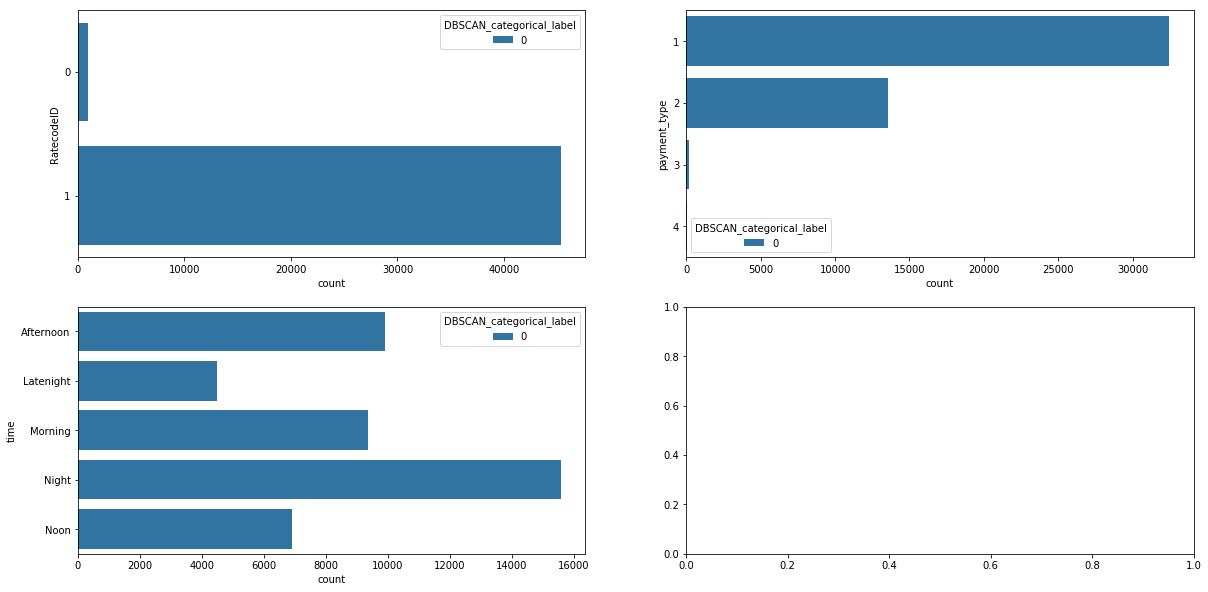

In [49]:
Visualize_DBSCAN(taxi_data_cluster = yellow_taxi_March_cluster, label = 'DBSCAN_categorical_label',
                 fig_width = 20, fig_height = 10)

# Green Taxi

In [14]:
start = time.time()
# Load the csv file into pandas dataframe
green_taxi_March = pd.read_csv('../data/green_tripdata_2018-03.csv')
# Preprocess the taxi data
green_taxi_March = taxi_data_preprocess(green_taxi_March, taxi_type = 'green')
# Add weather info
green_taxi_March = add_March_weather(taxi_data = green_taxi_March, taxi_type = 'green')
end = time.time()
print('Entire process took {:.2f} minutes'.format((end-start)/60))

Compute the duration of each taxi trip...
Create 5 different time period: morning, noon, afternoon, night, latenight...
Morning is done!
Noon is done!
Afternoon is done!
Night is done!
Latenight is done!
Remove unreasonable records...
Remove trip records whose dropoff time is earlier than pickup time...
Remove trip records that last longer than 24 hours or have negative duration time...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Compute the income per second for each trip in dollar amount...
Remove data points with extreme values in the following attributes: income_per_second, tip_amount, total_amount...
Reset row index...
Taxi data preprocess completed!
Add weather warnings for March data...
Weather warnings have been added!
Entire process took 0.50 minutes


In [15]:
start = time.time()
# Load the csv file into pandas dataframe
green_taxi_August = pd.read_csv('../data/green_tripdata_2018-08.csv')
# Preprocess the taxi data
green_taxi_August = taxi_data_preprocess(green_taxi_August, taxi_type = 'green')
# Add weather info
green_taxi_August = add_August_weather(taxi_data = green_taxi_August, taxi_type = 'green')
end = time.time()
print('Entire process took {:.2f} minutes'.format((end-start)/60))

Compute the duration of each taxi trip...
Create 5 different time period: morning, noon, afternoon, night, latenight...
Morning is done!
Noon is done!
Afternoon is done!
Night is done!
Latenight is done!
Remove unreasonable records...
Remove trip records whose dropoff time is earlier than pickup time...
Remove trip records that last longer than 24 hours or have negative duration time...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Compute the income per second for each trip in dollar amount...
Remove data points with extreme values in the following attributes: income_per_second, tip_amount, total_amount...
Reset row index...
Taxi data preprocess completed!
Add weather warnings for August data...
Weather warnings have been added!
Entire process took 0.41 minutes


## 1. Compare Driver Income by Different Time of a Day

### 1.1 Income per Second

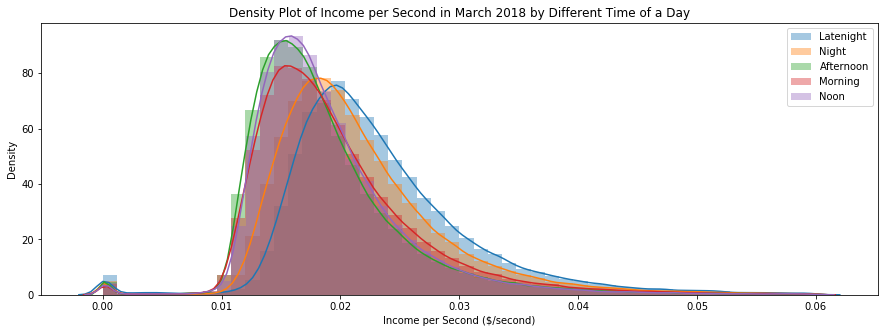

In [21]:
compare_time_density(taxi_data = green_taxi_March, feature = 'income_per_second', 
                     title = 'Density Plot of Income per Second in March 2018 by Different Time of a Day', 
                     xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

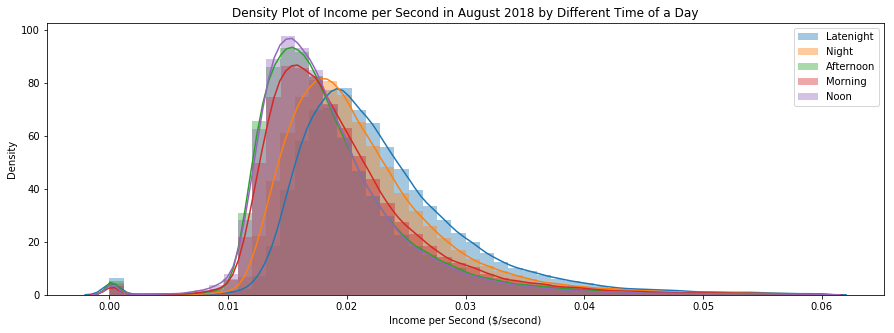

In [22]:
compare_time_density(taxi_data = green_taxi_August, feature = 'income_per_second', 
                     title = 'Density Plot of Income per Second in August 2018 by Different Time of a Day', 
                     xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

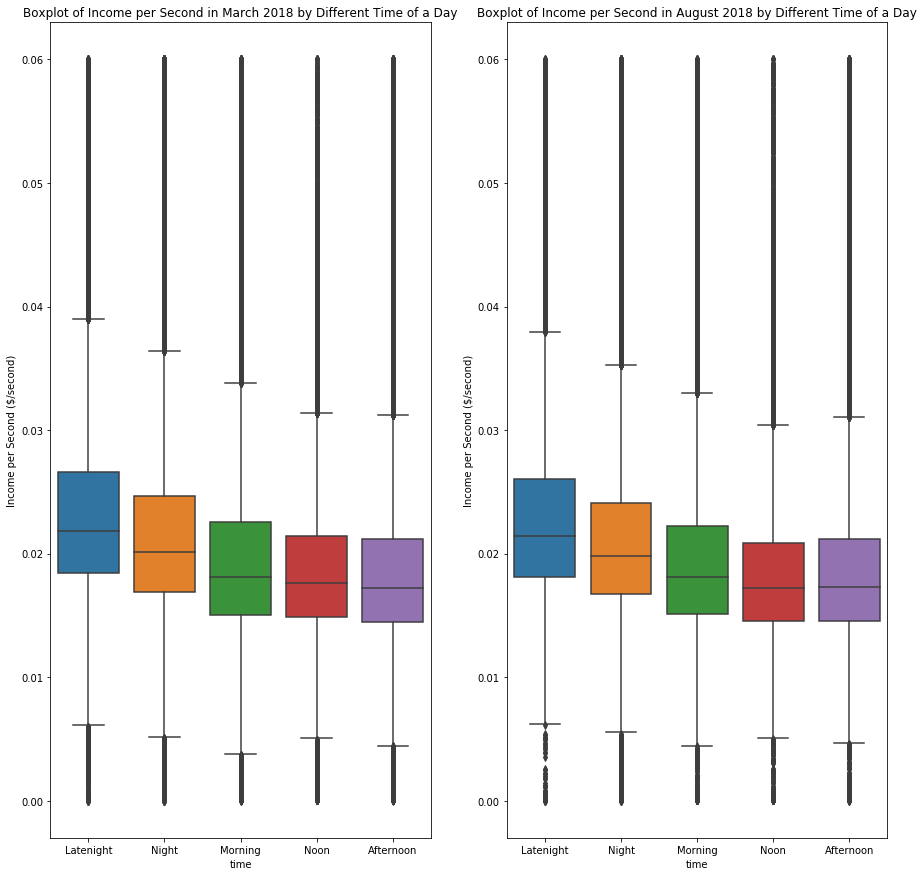

In [23]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,15))

compare_group_boxplot(taxi_data = green_taxi_March, group = 'time', feature = 'income_per_second', 
                      title = 'Boxplot of Income per Second in March 2018 by Different Time of a Day',
                      ylab = 'Income per Second ($/second)', ax = ax[0])
compare_group_boxplot(taxi_data = green_taxi_August, group = 'time', feature = 'income_per_second', 
                      title = 'Boxplot of Income per Second in August 2018 by Different Time of a Day',
                      ylab = 'Income per Second ($/second)', ax = ax[1])

### 1.2 Total Fare

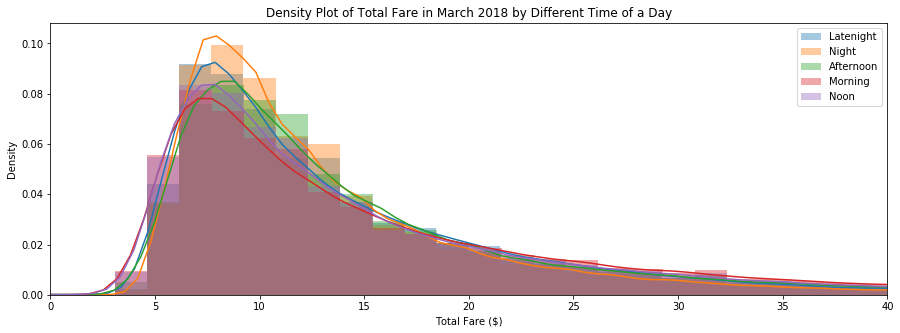

In [24]:
compare_time_density(taxi_data = green_taxi_March, feature = 'total_amount', xlim = 40,
                     title = 'Density Plot of Total Fare in March 2018 by Different Time of a Day', 
                     xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

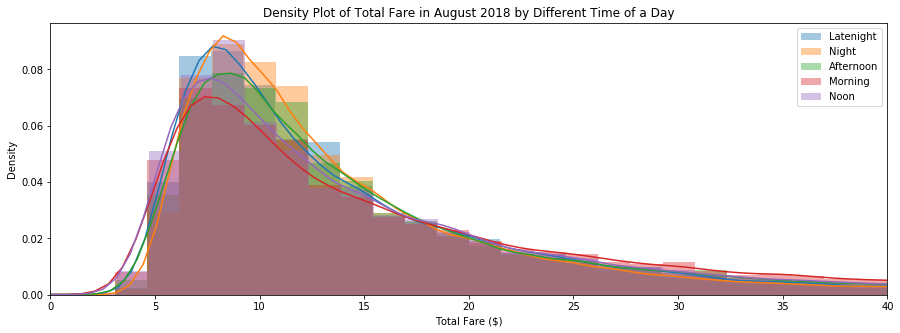

In [25]:
compare_time_density(taxi_data = green_taxi_August, feature = 'total_amount', xlim = 40,
                     title = 'Density Plot of Total Fare in August 2018 by Different Time of a Day', 
                     xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

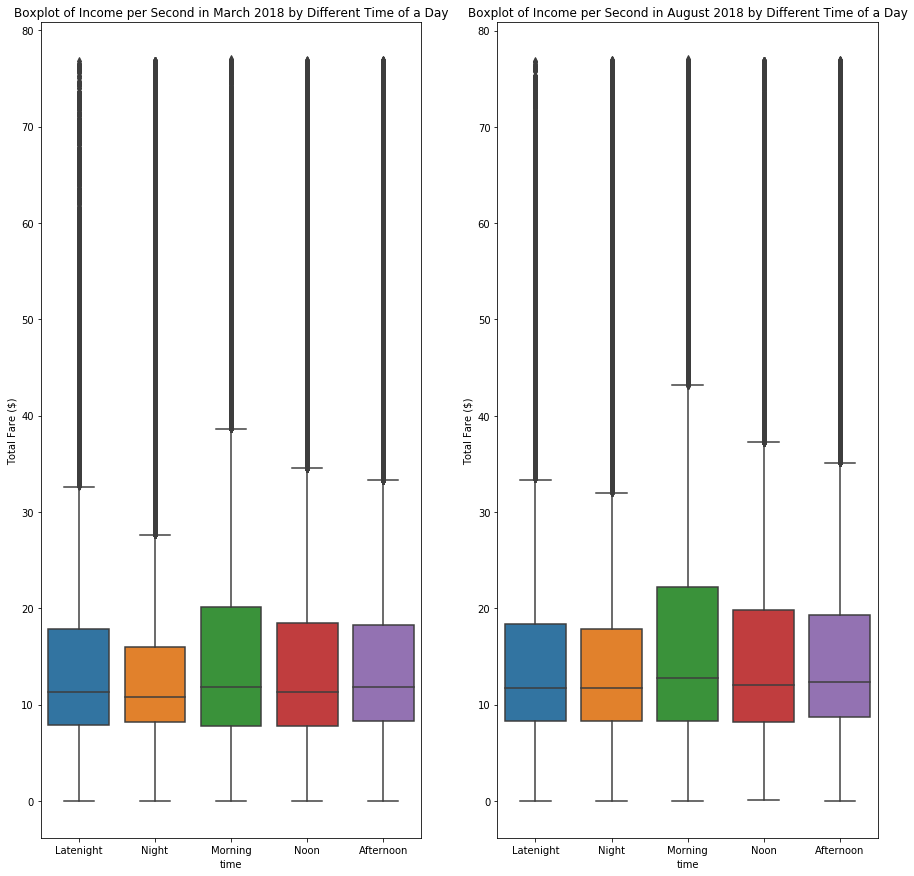

In [26]:
# Create four subplots (2x2)
fig, ax = plt.subplots(1,2,figsize=(15,15))

compare_group_boxplot(taxi_data = green_taxi_March, group = 'time', feature = 'total_amount', 
                      title = 'Boxplot of Income per Second in March 2018 by Different Time of a Day',
                      ylab = 'Total Fare ($)', ax = ax[0])
compare_group_boxplot(taxi_data = green_taxi_August, group = 'time', feature = 'total_amount', 
                      title = 'Boxplot of Income per Second in August 2018 by Different Time of a Day',
                      ylab = 'Total Fare ($)', ax = ax[1])

## 2. Compare Driver Income by Weather

### 2.1 Income per Second

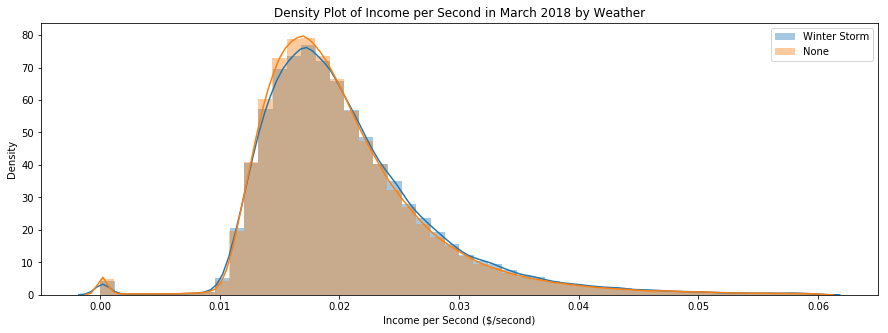

In [27]:
compare_WS_density(taxi_data = green_taxi_March, feature = 'income_per_second',
                   title = 'Density Plot of Income per Second in March 2018 by Weather',
                   xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

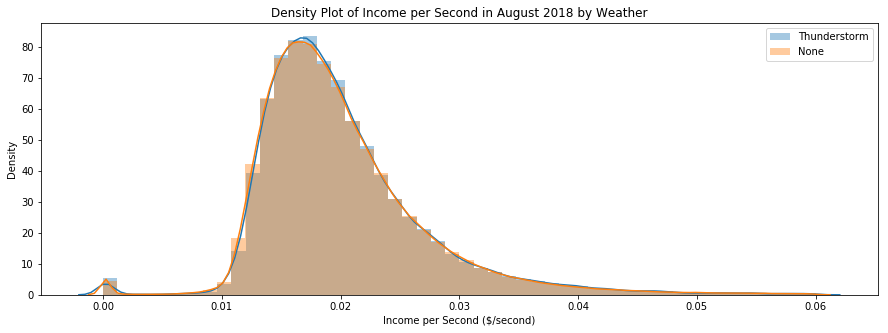

In [28]:
compare_SV_density(taxi_data = green_taxi_August, feature = 'income_per_second', 
                   title = 'Density Plot of Income per Second in August 2018 by Weather',
                   xlab = 'Income per Second ($/second)', fig_width = 15, fig_height = 5)

### 2.2 Total Fare

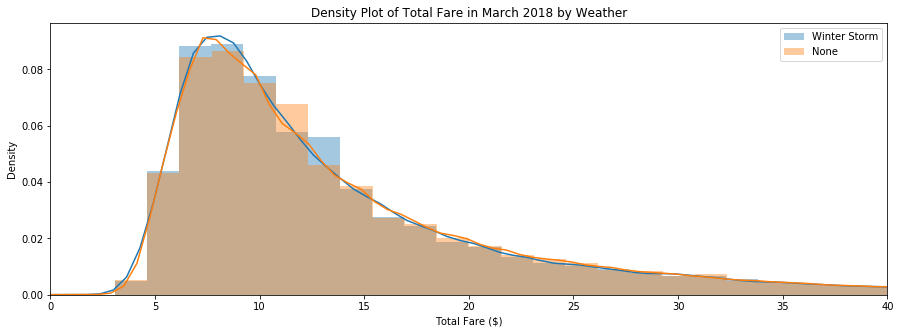

In [29]:
compare_WS_density(taxi_data = green_taxi_March, feature = 'total_amount', xlim = 40,
                   title = 'Density Plot of Total Fare in March 2018 by Weather',
                   xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

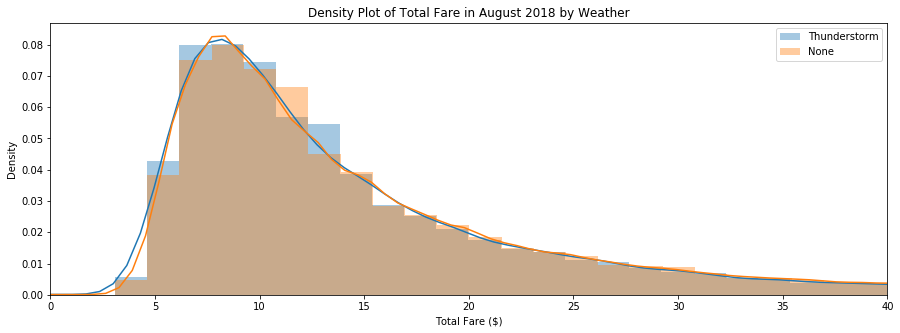

In [30]:
compare_SV_density(taxi_data = green_taxi_August, feature = 'total_amount', xlim = 40,
                   title = 'Density Plot of Total Fare in August 2018 by Weather',
                   xlab = 'Total Fare ($)', fig_width = 15, fig_height = 5)

## 3. Customer Profile - DBSCAN

In [27]:
numeric_attribute = ['passenger_count','trip_distance','total_amount','tip_amount','duration_seconds']
categorical_attribute = ['RatecodeID','payment_type','time']

### 3.1 Numeric Attributes

In [15]:
sample_ratio = 0.2
green_taxi_March_sample = green_taxi_March.groupby(['time']).apply(lambda x: x.sample(n = round(len(x)*sample_ratio), random_state = seed))
green_taxi_March_sample.reset_index(level=0,drop=True,inplace=True) # Drop multilevel index
green_taxi_March_sample['duration_seconds'] = [time.seconds for time in green_taxi_March_sample.duration]
green_taxi_March_sample.RatecodeID = ['1' if ID == 1 else '0' for ID in green_taxi_March_sample.RatecodeID]

In [16]:
green_taxi_March_sample.shape

(163446, 24)

In [25]:
green_DBSCAN_numeric = DBSCAN_taxi_data(taxi_data = green_taxi_March_sample, 
                                        min_sample_num = 100, numeric_feature = numeric_attribute)

Normalize numeric attributes...
Start the computation of DBSCAN...
DBSCAN on 163,446 data points took 10.18 minutes


In [26]:
green_taxi_March_cluster = green_taxi_March_sample
green_taxi_March_cluster['DBSCAN_numeric_label'] = green_DBSCAN_numeric.labels_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b70a5c0>,
      dtype=object)

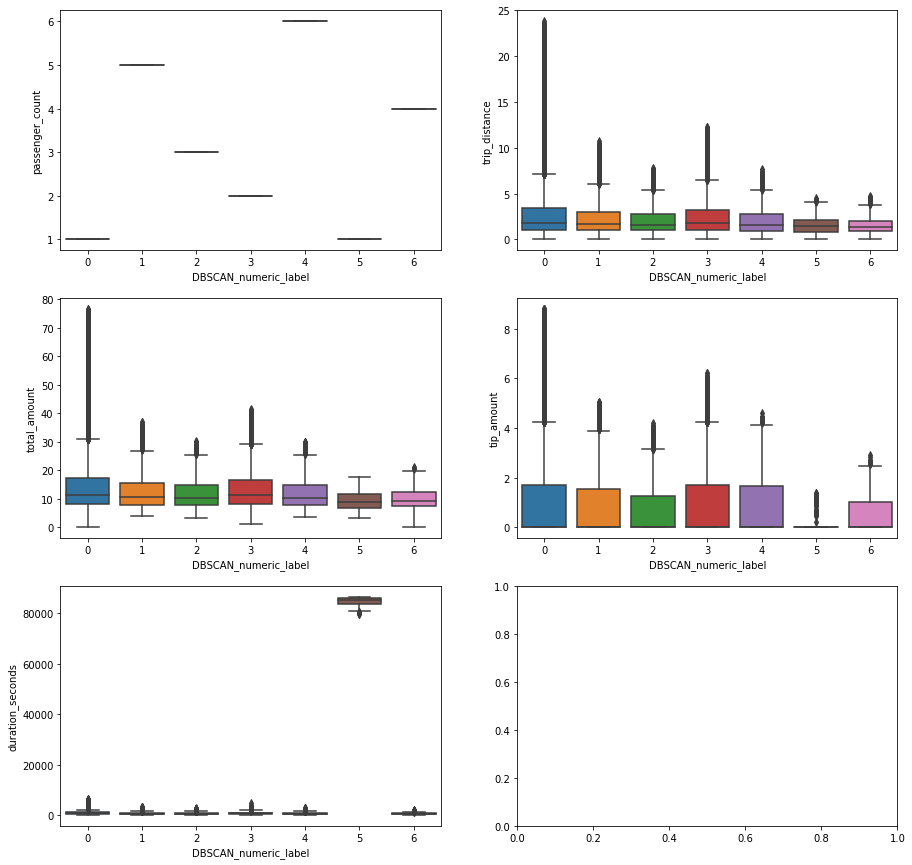

In [27]:
Visualize_DBSCAN(taxi_data_cluster = green_taxi_March_cluster, label = 'DBSCAN_numeric_label', 
                 fig_width = 15, fig_height = 15)

### 3.2 Categorical Attributes

In [24]:
sample_ratio = 0.1
green_taxi_March_sample = green_taxi_March.groupby(['time']).apply(lambda x: x.sample(n = round(len(x)*sample_ratio), random_state = seed))
green_taxi_March_sample.reset_index(level=0,drop=True,inplace=True) # Drop multilevel index
green_taxi_March_sample['duration_seconds'] = [time.seconds for time in green_taxi_March_sample.duration]
green_taxi_March_sample.RatecodeID = ['1' if ID == 1 else '0' for ID in green_taxi_March_sample.RatecodeID]

In [25]:
green_taxi_March_sample.shape

(81723, 24)

In [30]:
green_DBSCAN_categorical = DBSCAN_taxi_data(taxi_data = green_taxi_March_sample,
                                            min_sample_num = 100, categorical_feature = categorical_attribute)

One-Hot encoding categorical attributes...


ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

In [ ]:
green_taxi_March_cluster['DBSCAN_categorical_label'] = green_DBSCAN_categorical.labels_

In [ ]:
Visualize_DBSCAN(taxi_data_cluster = green_taxi_March_cluster, label = 'DBSCAN_categorical_label',
                 fig_width = 20, fig_height = 10)